# 2. Mājasdarbs. Oļegs Korsaks 051RDB146
• Atrast datu kopu internetā. Piemēram no Awesomedata vai UCI Machine Learning

Repository vai citur

– Vēlams ar simtiem līdz tūkstošiem ierakstiem,

– Vēlams desmitiem atribūtiem,

– Skaitliskās vērtības atribūtos,

– Ar mērķa klasi/klasēm, bet var arī nepārtraukta vērtība,

– Dažām datu kopām var nebūt izvirzīta mērķa klase. Šādos gadījumos var izmantot vienu no atribūtiem par mērķa klasi (ja ir iespējams loģiski pamatot).

• Sadalīt datu kopu apmācības un testa kopās.

• Izveidot daudzslāņu mākslīgo neironu tīklu ar tensorflow un veikt apmācību.

• Aprēķināt un novērtēt apmācības un testa kopas kļūdu.

• Pamainīt tīkla konfigurāciju un novērtēt izmaiņu ietekmi

– Arhitektūru – slēpto slāņu skaits, neironu skaits slāņos,

– Aktivācijas funkcijas,

– Optimizācijas metodi.

In [1]:
import datetime
import os
import random

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)

        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=2600)]
        )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f'{len(gpus)} Physical GPUs, {len(logical_gpus)} Logical GPUs')
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

%load_ext tensorboard

sns.set_context('notebook', font_scale=2.0)
sns.set_style('darkgrid')

from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt

%matplotlib inline

from sklearn.model_selection import train_test_split

2021-12-29 02:26:13.018577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2021-12-29 02:26:13.210517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 02:26:13.210927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-29 02:26:13.236659: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-29 02:26:13.253272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [2]:
SEED = 42
EPOCHS = 2000
BATCH_SIZE = 16
TF_DEVICE = '/gpu:0' if gpus else '/cpu:0'

In [3]:
# def set_seeds(seed=SEED):
#     os.environ['PYTHONHASHSEED'] = str(seed)
#     random.seed(seed)
#     tf.random.set_seed(seed)
#     np.random.seed(seed)
#
#
# def set_global_determinism(seed=SEED):
#     set_seeds(seed=seed)
#
#     os.environ['TF_DETERMINISTIC_OPS'] = '1'
#     os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
#
#     tf.config.threading.set_inter_op_parallelism_threads(1)
#     tf.config.threading.set_intra_op_parallelism_threads(1)
#
#
# # Call the above function with seed value
# set_global_determinism(seed=SEED)

## Datu ielāde

In [4]:
data = pd.read_csv('data/winequality-white.csv', sep=';')

### Datu analīze

In [5]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,4898.0,6.854788,0.843868,3.80000,6.300000,6.80000,7.3000,14.20000
volatile acidity,4898.0,0.278241,0.100795,0.08000,0.210000,0.26000,0.3200,1.10000
citric acid,4898.0,0.334192,0.121020,0.00000,0.270000,0.32000,0.3900,1.66000
residual sugar,4898.0,6.391415,5.072058,0.60000,1.700000,5.20000,9.9000,65.80000
chlorides,4898.0,0.045772,0.021848,0.00900,0.036000,0.04300,0.0500,0.34600
free sulfur dioxide,4898.0,35.308085,17.007137,2.00000,23.000000,34.00000,46.0000,289.00000
total sulfur dioxide,4898.0,138.360657,42.498065,9.00000,108.000000,134.00000,167.0000,440.00000
density,4898.0,0.994027,0.002991,0.98711,0.991723,0.99374,0.9961,1.03898
pH,4898.0,3.188267,0.151001,2.72000,3.090000,3.18000,3.2800,3.82000
sulphates,4898.0,0.489847,0.114126,0.22000,0.410000,0.47000,0.5500,1.08000


## Datu vizualizācija un analīze

Paskatīsimies, vai ir dati, kuru vērtības ļoti atšķiras no vairuma.

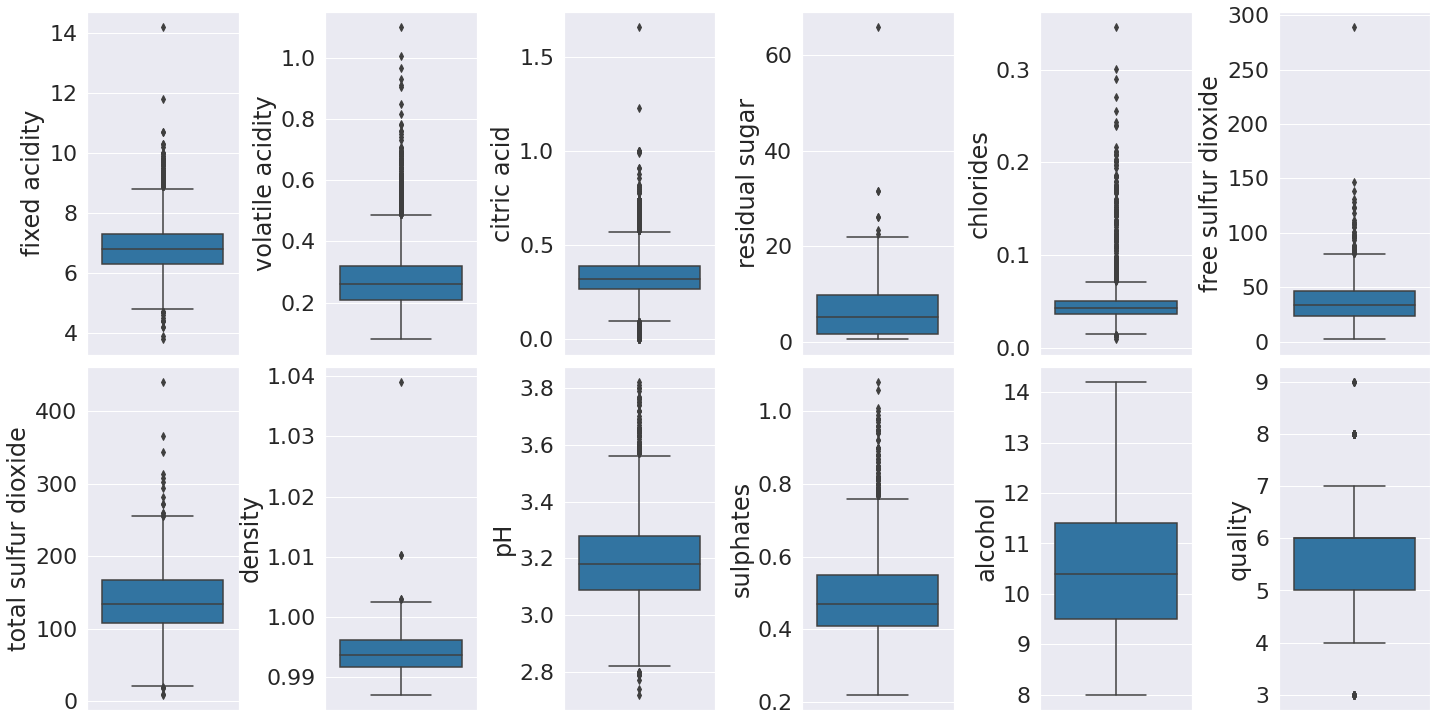

In [8]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.boxplot(y=col, data=data, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

Dažiem (piem. "total sulfur dioxide") ir tādas vērtības. Varbūt tie ietekmēs precizitāti.

Paskatīsimies uz vērtību sadali.

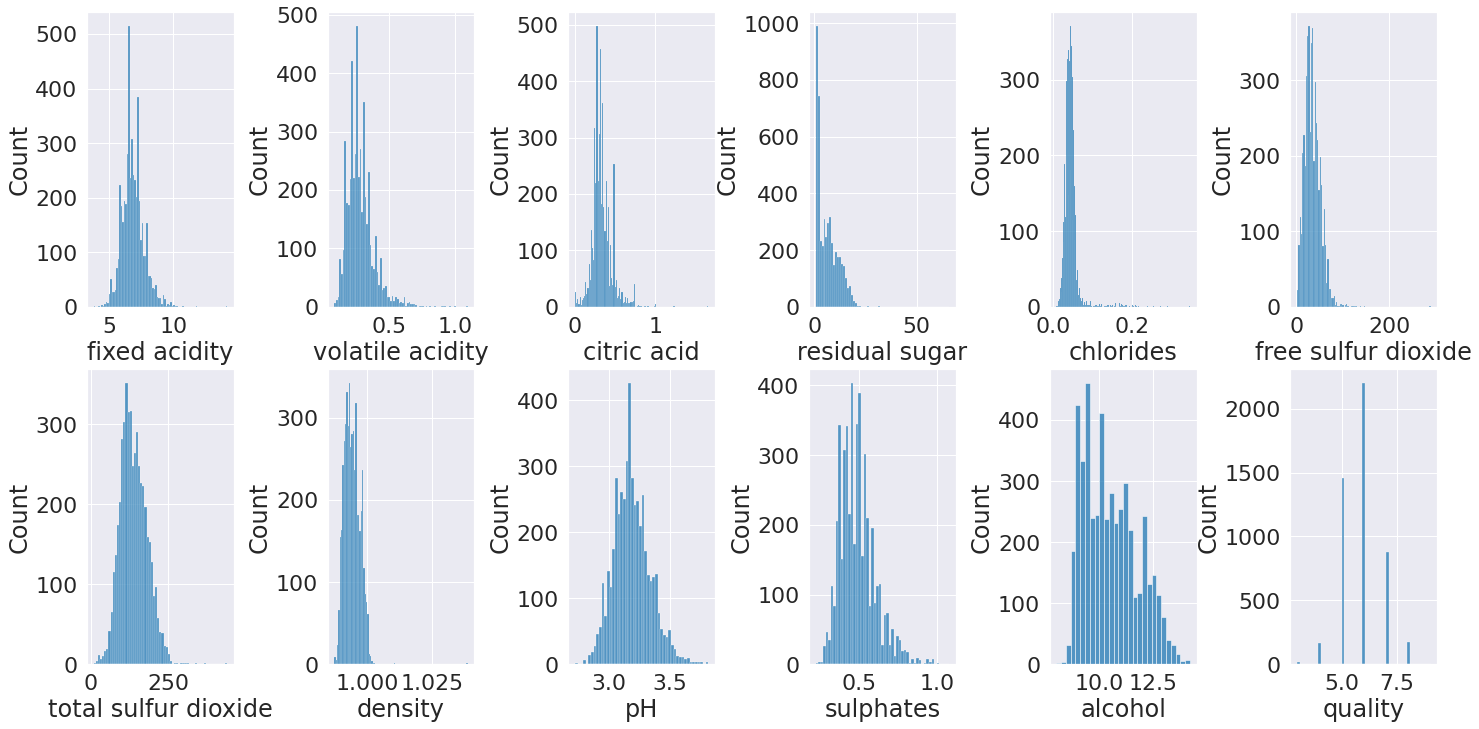

In [9]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in data.items():
    sns.histplot(value, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

Daži paramtetri satur ļoti lielas vērtības. Kā arī ne visi ir normālizēti.

<AxesSubplot:xlabel='quality', ylabel='count'>

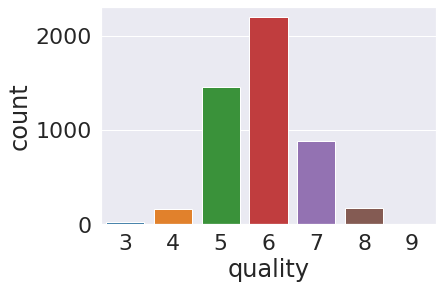

In [10]:
sns.countplot(x=data['quality'])

Mums pārsvārā ir vērtības 5, 6 un pat nav dažu vērtību vispār. Tāda klašu nelīdzsvarotība nozīmē, ka modelis varēs labi noklasificēt tikai 5. un 6. kvalitātes gadījumus.

### Paramtetru korelācija

<AxesSubplot:>

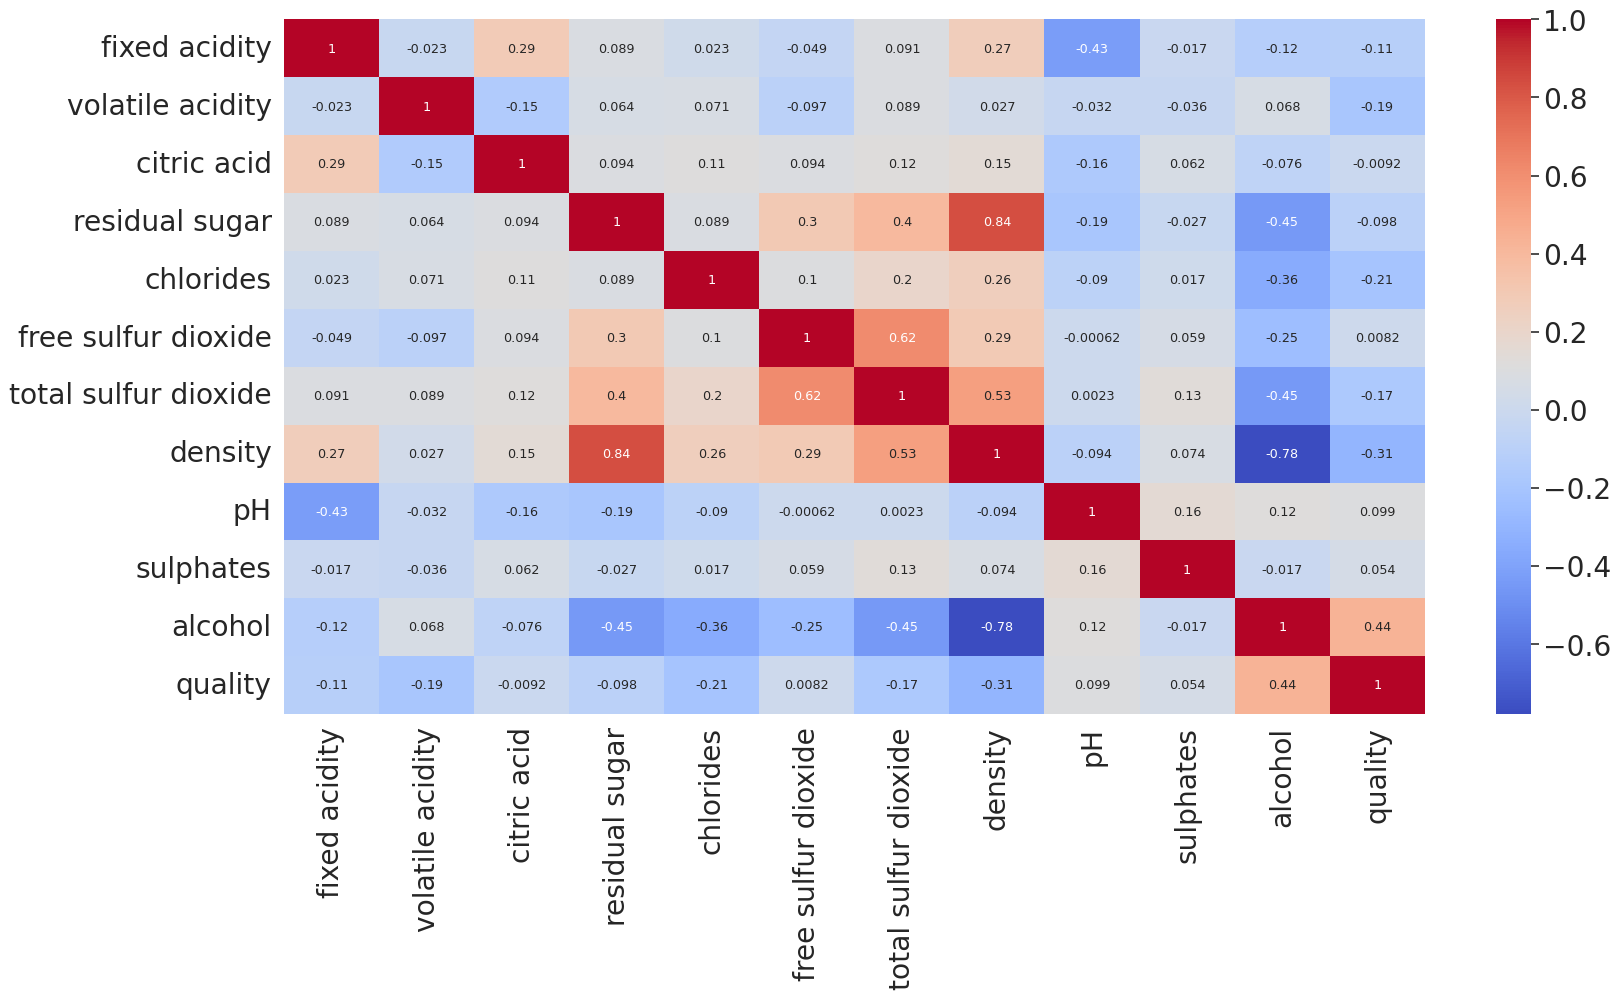

In [11]:
corr = data.corr()
plt.figure(figsize=(20, 10), dpi=92)
sns.heatmap(corr, annot=True, cmap='coolwarm')

Ir līdzīgi parametri tādi kā "free sulfur dioxide" in "total sulfur dioxide". Izskatas, ka viens ar otru pozitīvi korelē. Bet kvalitāti ietekmē tikai alkohols. Un pat tam ir vāja (0.3 - 0.5) korelācija ar kvalitāti. Izskatas, ka paņemu ne tik labus datus un kvalitāte tika noteikta ne no parametriem, bet no kāda alkoholiķa prāta. Neskatoties uz pazaudēto nedēļu (ne tik atri sapratu, kāpēc nav tik liela precizitāte) taisīšu uzdevumus ar visu šo, jo noteikt kļūdu var vienalga.

Atdalīsim kvalitāti atsevišķā kopā.

In [12]:
samples = data.copy()
qualities = samples.pop('quality')

In [13]:
attr_count = len(samples.keys())
print(attr_count, len(qualities.value_counts()))

11 7


Mums ir 11 atribūti un 7 klases, jo nav datu priekš citām klasēm.

In [14]:
def plot_history(history, metric='mse'):
    plt.figure(figsize=(18, 10), dpi=92)
    plt.plot(history.history['loss'])
    plt.plot(history.history[f'val_loss'])
    plt.title('model_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validate loss'], loc='best')
    plt.show()

In [15]:
def evaluate_model(model, samples, qualities, epochs=100, batch_size=BATCH_SIZE, metric='mae'):
    samples_train, samples_test, qualities_train, qualities_test = train_test_split(samples,
                                                                                    qualities,
                                                                                    test_size=0.25,
                                                                                    shuffle=True)

    with tf.device(TF_DEVICE):
        samples_train = tf.constant(samples_train, dtype=tf.float64)
        samples_test = tf.constant(samples_test, dtype=tf.float64)
        qualities_train = tf.constant(np.asarray(list(qualities_train)).astype(np.int64), dtype=tf.int64)
        qualities_test = tf.constant(np.asarray(list(qualities_test)).astype(np.int64), dtype=tf.int64)

        log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


        try:
            history = model.fit(
                samples_train, qualities_train,
                validation_data=(samples_test, qualities_test),
                shuffle=False, epochs=epochs, batch_size=batch_size,
                verbose=0, callbacks=[tensorboard_callback]
            )
        except KeyboardInterrupt:
            raise
        else:
            plot_history(history, metric)
        finally:
            evaluate_result = model.evaluate(samples_test, qualities_test, verbose=False)
            print(f'Test loss: {evaluate_result}')
            evaluate_result = model.evaluate(samples_test, qualities_test, batch_size=4096, verbose=False)
            print(f'Test loss: {evaluate_result}')

            predict_result = model.predict(samples_test)

            for sample_idx in (5, 7, 10, 20, 30, 50, -5, -7, -10, -20, -30, -50):
                print(f'Predicted: {predict_result[sample_idx]}, Expected: {qualities_test[sample_idx]}')

## Lineāras regressijas metode

In [16]:
def build_model(input_count: int):
    kreg = tf.keras.regularizers.l2(0.1)
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(1, kernel_regularizer=kreg)
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.75)

    model.compile(loss='mse', optimizer=optimizer)

    return model

In [17]:
%%time
model = build_model(attr_count)
evaluate_model(model, samples, qualities, batch_size=2, epochs=EPOCHS*2)

Test loss: 0.6912655234336853
Test loss: 0.6912655234336853
Predicted: [5.645134], Expected: 6
Predicted: [6.0373917], Expected: 6
Predicted: [5.6600084], Expected: 5
Predicted: [6.084191], Expected: 8
Predicted: [6.8116245], Expected: 7
Predicted: [6.5325174], Expected: 6
Predicted: [6.2183948], Expected: 6
Predicted: [5.9173675], Expected: 5
Predicted: [5.8441987], Expected: 5
Predicted: [6.460089], Expected: 6
Predicted: [5.589177], Expected: 4
Predicted: [5.997105], Expected: 5


KeyboardInterrupt: 

Nu vispār nav tik slikti :)) Pamēģināšu to pašu modeli ar x10 lielāko learning rate.

In [17]:
def build_model(input_count: int):
    kinit = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
    kreg = tf.keras.regularizers.l2(0.1)
    breg = tf.keras.regularizers.l2(0.1)
    areg = tf.keras.regularizers.l2(0.2)
    binit = tf.keras.initializers.Zeros()
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count, kernel_initializer=kinit, kernel_regularizer=kreg, bias_initializer=binit, bias_regularizer=breg, activity_regularizer=areg, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.5)

    model.compile(loss='mse', optimizer=optimizer)

    return model

In [19]:
%%time
model = build_model(attr_count)
evaluate_model(model, samples, qualities, batch_size=2, epochs=EPOCHS*2)

Test loss: 878.3796997070312
Test loss: 878.3798217773438
Predicted: [3.3594153], Expected: 7
Predicted: [4.2570367], Expected: 6
Predicted: [4.257661], Expected: 6
Predicted: [5.417856], Expected: 6
Predicted: [3.853044], Expected: 6
Predicted: [5.9179506], Expected: 7
Predicted: [7.2178206], Expected: 5
Predicted: [6.2239113], Expected: 6
Predicted: [4.872293], Expected: 7
Predicted: [1.4909359], Expected: 7
Predicted: [3.9604008], Expected: 6
Predicted: [5.8224063], Expected: 6


KeyboardInterrupt: 

Pameģināšu normalizēt parametru vērtības.

In [16]:
n_samples = data.copy()
n_qualities = n_samples.pop('quality')
n_samples = (n_samples - n_samples.mean()) / n_samples.std()

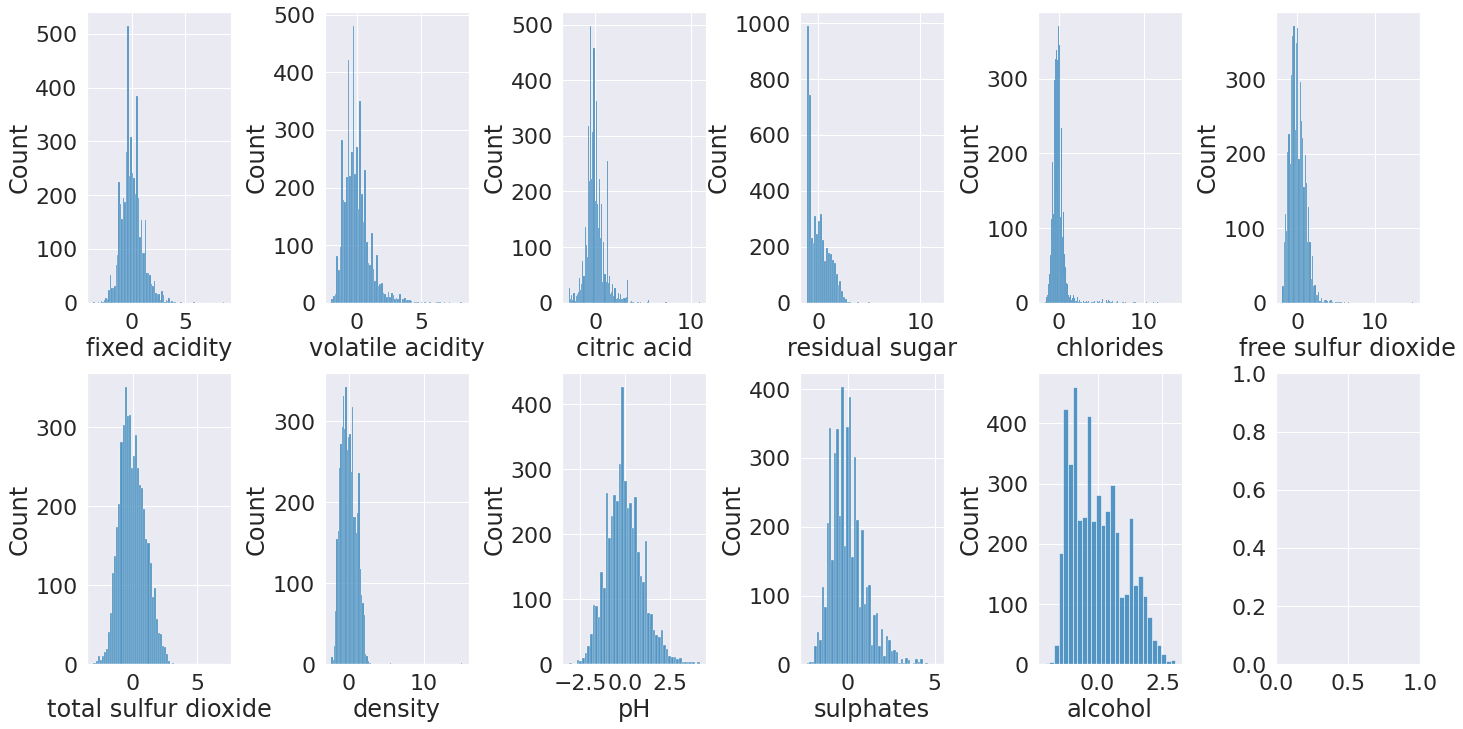

In [17]:
fig, ax = plt.subplots(ncols=6, nrows=2, figsize=(20, 10))
index = 0
ax = ax.flatten()

for col, value in n_samples.items():
    sns.histplot(value, ax=ax[index])
    index += 1

plt.tight_layout(pad=0.5, w_pad=0.0)

In [20]:
%%time
model = build_model(attr_count)
evaluate_model(model, n_samples, n_qualities, batch_size=2, epochs=EPOCHS*2)

Test loss: 19.915142059326172
Test loss: 19.915138244628906
Predicted: [3.628857], Expected: 5
Predicted: [6.468687], Expected: 5
Predicted: [5.1574883], Expected: 7
Predicted: [2.5994446], Expected: 6
Predicted: [4.419693], Expected: 6
Predicted: [5.3739977], Expected: 6
Predicted: [3.4343765], Expected: 5
Predicted: [5.0680466], Expected: 5
Predicted: [4.2581167], Expected: 8
Predicted: [5.3257565], Expected: 5
Predicted: [5.430479], Expected: 6
Predicted: [8.386586], Expected: 3


KeyboardInterrupt: 

## Klasifikācijas metode

In [18]:
classes = {
    3: np.asarray([1, 0, 0, 0, 0, 0, 0], dtype=np.int64),
    4: np.asarray([0, 1, 0, 0, 0, 0, 0], dtype=np.int64),
    5: np.asarray([0, 0, 1, 0, 0, 0, 0], dtype=np.int64),
    6: np.asarray([0, 0, 0, 1, 0, 0, 0], dtype=np.int64),
    7: np.asarray([0, 0, 0, 0, 1, 0, 0], dtype=np.int64),
    8: np.asarray([0, 0, 0, 0, 0, 1, 0], dtype=np.int64),
    9: np.asarray([0, 0, 0, 0, 0, 0, 1], dtype=np.int64),
}

n_samples = data.copy()

# n_samples = n_samples.drop(['sulphates', 'volatile acidity', 'citric acid', 'free sulfur dioxide'], axis=1)
n_qualities = n_samples.pop('quality')
# n_samples = n_samples.filter(['density'])

smote = SMOTE(k_neighbors=4)
smote_enn = SMOTEENN(smote=smote, random_state=0)

n_samples, n_qualities = smote_enn.fit_resample(n_samples, n_qualities)

n_qualities = n_qualities.map(classes)
# n_samples = (n_samples - n_samples.mean()) / n_samples.std()

In [19]:
def build_model(input_count: int, output_count: int):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(input_count),
        tf.keras.layers.Dense(input_count*2,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0),
                              bias_regularizer=tf.keras.regularizers.l2(0.001),
                              activity_regularizer=tf.keras.regularizers.l2(0.001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count*2,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0),
                              bias_regularizer=tf.keras.regularizers.l2(0.001),
                              activity_regularizer=tf.keras.regularizers.l2(0.001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(input_count*2,
                              kernel_regularizer=tf.keras.regularizers.l2(0.001),
                              kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0),
                              bias_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.0),
                              bias_regularizer=tf.keras.regularizers.l2(0.001),
                              activity_regularizer=tf.keras.regularizers.l2(0.001),
                              activation='sigmoid'),
        tf.keras.layers.Dense(output_count,
                              activation='softmax')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [20]:
model = build_model(attr_count, len(classes))
model.load_weights('data/models/001_weights')

In [ ]:
%%time
evaluate_model(model, n_samples, n_qualities, batch_size=64, epochs=20000000)

In [40]:
model.save_weights('data/models/001_weights')